[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/search/image/satellite-image-search/satellite-image-search.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/search/image/satellite-image-search/satellite-image-search.ipynb)

# Satellite Image Search with Pinecone

In this notebook, we will demonstrate how Pinecone can be used for Satellite Image Search. Our objective is to showcase how Pinecone's vector search can be used to efficiently and effectively find satellite images that are similar to a given query image.

To achieve this, we will:

1. Download satellite image dataset and prepare them for vectorization.
2. Use a pre-trained model fine-tuned on aerial and satellite images to generate embeddings for each image in the dataset.
3. Store the image embeddings in a Pinecone index along with image paths as metadata.
4. Use a query image to search the Pinecone index for similar satellite images based on their vector representation.
5. Visualize the retrieved images to evaluate the effectiveness of the search.

Satellite image search can be useful in various applications such as urban planning, environmental monitoring, and disaster response. By leveraging the power of Pinecone's vector search, we can quickly search through a large database of satellite images to find those that are most relevant to our needs.

Let's get started.

# Setup Notebook and Install dependencies

Install the necessary libraries for running this notebook. Those are:

In [6]:
!pip install -qU transformers pinecone-client

# Download and prepare the dataset

We will be using the [LoveDa](https://github.com/Junjue-Wang/LoveDA) dataset, which is a collection of 5987 high spatial resolution remote sensing images with a resolution of 0.3 meters. The dataset covers three cities in China - Nanjing, Changzhou, and Wuhan - and focuses on different geographical environments between urban and rural areas. The dataset's high spatial resolution and focus on different geographical environments between urban and rural areas makes it a suitable choice for our demonstration of Pinecone's vector search capabilities for satellite image retrieval.

We will be downloading the LoveDa dataset using the ```gdown``` library and unzipping the files using the ```unzip``` command.

*Note if not running this on Colab, you may need to run `!pip install gdown` first!*

In [7]:
!gdown --id 1ON7bWat7u9fGV16stAosdmzMIpcydnVC
!gdown --id 1xbnKVN5aRMlpxISXgutzQO0hPT_b4lMi
!gdown --id 1yTMfeon1Oc4ia9oCX7r5Yq4C39I0oO_b

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ON7bWat7u9fGV16stAosdmzMIpcydnVC
To: /content/Test.zip
100% 3.13G/3.13G [00:43<00:00, 71.4MB/s]
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1xbnKVN5aRMlpxISXgutzQO0hPT_b4lMi 

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in versi

In [8]:
!unzip Test.zip
!unzip Train.zip
!unzip Val.zip

Archive:  Test.zip
   creating: Test/
   creating: Test/Rural/
   creating: Test/Rural/images_png/
  inflating: Test/Rural/images_png/4191.png  
  inflating: Test/Rural/images_png/4192.png  
 extracting: Test/Rural/images_png/4193.png  
 extracting: Test/Rural/images_png/4194.png  
 extracting: Test/Rural/images_png/4195.png  
 extracting: Test/Rural/images_png/4196.png  
 extracting: Test/Rural/images_png/4197.png  
 extracting: Test/Rural/images_png/4198.png  
 extracting: Test/Rural/images_png/4199.png  
  inflating: Test/Rural/images_png/4200.png  
 extracting: Test/Rural/images_png/4201.png  
 extracting: Test/Rural/images_png/4202.png  
 extracting: Test/Rural/images_png/4203.png  
 extracting: Test/Rural/images_png/4204.png  
 extracting: Test/Rural/images_png/4205.png  
  inflating: Test/Rural/images_png/4206.png  
  inflating: Test/Rural/images_png/4207.png  
 extracting: Test/Rural/images_png/4208.png  
 extracting: Test/Rural/images_png/4209.png  
 extracting: Test/Rural/ima

The dataset we've extracted is structured into folders as follows:

```
├── Test/
│   ├── Rural/
│   │   ├── images_png/
│   │   │   ├── image_1.png
│   │   │   ├── image_2.png
│   │   │   ├── ...
│   ├── Urban/
│       ├── images_png/
│           ├── image_1.png
│           ├── image_2.png
│           ├── ...
├── Train/
│   ├── Rural/
│   │   ├── images_png/
│   │   │   ├── image_1.png
│   │   │   ├── image_2.png
│   │   │   ├── ...
│   ├── Urban/
│       ├── images_png/
│           ├── image_1.png
│           ├── image_2.png
│           ├── ...
├── Val/
    ├── Rural/
    │   ├── images_png/
    │   │   ├── image_1.png
    │   │   ├── image_2.png
    │   │   ├── ...
    ├── Urban/
        ├── images_png/
            ├── image_1.png
            ├── image_2.png
            ├── ...
```

Let's retrieve all the paths to the images in the dataset. This will allow us to load the images in an iterative manner as needed later on.

In [9]:
from pathlib import Path

# create an empty list to store image paths
image_paths = []

# create a list of splits
splits = ['Test', 'Train', 'Val']
# loop through each split
for split in splits:
    # get all relevant .png image files
    image_paths.extend([
        str(x) for x in Path(split).glob('**/images_png/*.png')
    ])
# check how many images we return
len(image_paths)

1796

Every image path will look something like this:

In [10]:
image_paths[-1]

'Test/Rural/images_png/4776.png'

We can load a batch of images using the following function.

In [11]:
from PIL import Image

def load_images(paths):
    # create empty lists to store images and metadata
    images = []
    metadata = []
    # loop through each file path in the input list
    for path in paths:
        # open the image at the file path and convert it to RGB format
        img = Image.open(path).convert("RGB")
        # append the image to the list of images and include path in metadata
        images.append(img)
        metadata.append({"path": path})
    # Return the lists of images and metadata
    return images, metadata

In [12]:
images, metadata = load_images(image_paths[:3])

In [13]:
images

[<PIL.Image.Image image mode=RGB size=1024x1024 at 0x7F3A113585E0>,
 <PIL.Image.Image image mode=RGB size=1024x1024 at 0x7F3A100379A0>,
 <PIL.Image.Image image mode=RGB size=1024x1024 at 0x7F3A10037220>]

In [14]:
metadata

[{'path': 'Test/Urban/images_png/5832.png'},
 {'path': 'Test/Urban/images_png/5229.png'},
 {'path': 'Test/Urban/images_png/5566.png'}]

# Initialize Pinecone Index

The Pinecone index stores vector representations of our satellite images, which we can retrieve later using another satellite or aerial image in vector form (query vector). We need an API key from Pinecone to initialize the index. You can get one for free from [here](https://app.pinecone.io/).

In [15]:
import pinecone

# connect to pinecone environment
pinecone.init(
    api_key="YOUR_API_KEY",  # app.pinecone.io
    environment="YOUR_ENV"  # find next to API key in console
)

/usr/local/lib/python3.9/dist-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Now we create a new index with metric set as "cosine" and dimension as 512 because the CLIP model we use to generate embeddings generate 512-dimension vectors.

In [16]:
index_name = "satellite-image-search"

# check if the satellite-image-search index exists
if index_name not in pinecone.list_indexes().names():
    # create the index if it does not exist
    pinecone.create_index(
        index_name,
        dimension=512,  # align this to CLIP model we'll user later
        metric="cosine"
    )

# connect to satellite-image-search index we created
index = pinecone.Index(index_name)

# Initialize the Embedding Model

We will be using a [CLIP](https://huggingface.co/blog/fine-tune-clip-rsicd) model that has been fine-tuned on satellite images and captions from the [RSICD](https://github.com/201528014227051/RSICD_optimal) dataset to generate embeddings for the satellite images. This pre-trained model is readily available on the Hugging Face model hub, and we can load it as follows:

In [17]:
from transformers import CLIPProcessor, FlaxCLIPModel

# set the model path
model_path = "flax-community/clip-rsicd-v2"
# initialize the CLIPProcessor using the pretrained model
processor = CLIPProcessor.from_pretrained(model_path)
# initialize the FlaxCLIPModel using the pretrained model
model = FlaxCLIPModel.from_pretrained(model_path)

We can use the below function to generate embeddings using the CLIP model.

In [18]:
def embed_images(images):
  # converts the images into model-acceptable inputs and applies padding
  inputs = processor(images=images, return_tensors="jax", padding=True)
  # passes the images through the CLIP model and extracts image features
  emb = model.get_image_features(**inputs)
  # converts the embedding vectors into a Python list and returns them
  return emb.tolist()

# Generate Embeddings and Upsert

Next, we need to generate embeddings for satellite images. We will do this in batches to help us more quickly generate embeddings and upload them to the Pinecone index. When passing the images to Pinecone, we need an id (a unique value), image embedding, and metadata for each image representing satellite images in the dataset. The metadata is a dictionary containing data relevant to our embeddings, such as the image file paths.

In [19]:
from tqdm.auto import tqdm

# we will use batches of 64
batch_size = 64

for i in tqdm(range(0, len(image_paths), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(image_paths))
    # extract batch
    paths = image_paths[i:i_end]
    images, meta = load_images(paths)
    # generate embeddings for batch
    emb = embed_images(images)
    # create unique IDs
    ids = [f"{idx}" for idx in range(i, i_end)]
    # add all to upsert list
    to_upsert = list(zip(ids, emb, meta))
    # upsert/insert these records to pinecone
    _ = index.upsert(vectors=to_upsert)

# check that we have all vectors in index
index.describe_index_stats()

  0%|          | 0/29 [00:00<?, ?it/s]

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1796}},
 'total_vector_count': 1796}

Now the index is ready for querying.

# Querying

First, let's write some helper functions to generate embeddings and search pinecone for similar images and for display the results.

The `search_pinecone` function will handle the query embedding, retrieval, and return of images and their respective metadata:

In [20]:
def search_pinecone(image):
    # generate an embedding for the input image
    query_emb = embed_images(image)
    # query pinecone to find the top 6 most similar images to the input image
    result = index.query(query_emb, top_k=6, include_metadata=True)
    # extract the image paths from the search results
    result_image_paths = [x["metadata"]["path"] for x in result["matches"]]
    # load the images corresponding to the paths extracted in the previous step
    imgs, meta = load_images(result_image_paths)
    # Return the loaded images and metadata as output of the function
    return imgs, meta

The `display_result` will let us generate HTML for display product images:

In [21]:
from IPython.core.display import HTML
from base64 import b64encode
from io import BytesIO


# function to display product images
def display_result(images):
    figures = []
    for img in images:
        img = img.resize((200,200))
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 200px; height: 200px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
      ''')

And the `display_result` function will allow us to show the results in the notebook.

In [22]:
from IPython.core.display import HTML
from base64 import b64encode
from io import BytesIO


def display_result(images):
    # initialize an empty list to hold the figures generated from the images
    figures = []
    # iterate through each image in the input list
    for img in images: 
        # resize the image to have dimensions of 200x200 pixels
        img = img.resize((200,200))
        # create a BytesIO object to hold the image data
        b = BytesIO()
        # save the image data in PNG format to the BytesIO object
        img.save(b, format='png')
        # append an HTML figure element to the "figures" list for the current image
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 200px; height: 200px" >
            </figure>
        ''')
    # concatenate the HTML figure elements into a string and wrap them in a div element
    # return the HTML string as output of the function
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
      ''')

First, let's load an image from the dataset and do a test search.

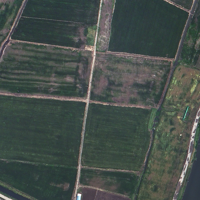

In [23]:
query_image, _ = load_images([image_paths[1524]]) #654
query_image[0].resize((200,200))

In [24]:
imgs, meta = search_pinecone(query_image)


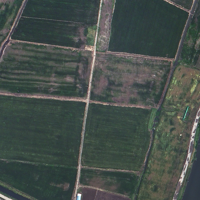
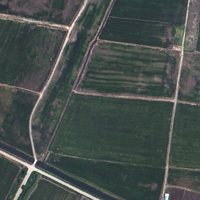
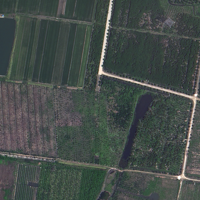
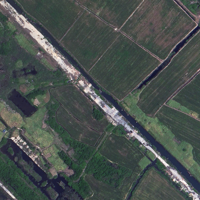
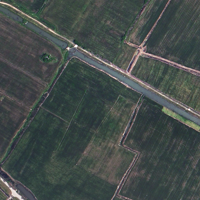
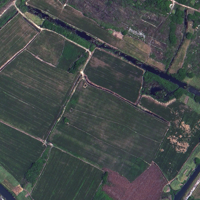

In [25]:
display_result(imgs)

We can see that the search is working as expected, and the Pinecone index is correctly retrieving similar images. 

We are not limited to using images only from the our dataset. We can also load satellite or aerial images from the web and conduct a search to identify similar objects or structures. Let's write a helper function to load an image from url and test this.

In [27]:
import requests

def load_image_from_url(url):
  # fetch the image from the URL using the requests library
  image_raw = requests.get(url, stream=True,).raw
  # open the image and converting it to RGB format
  image = Image.open(image_raw).convert("RGB")
  # return the RGB PIL image object
  return image

In [28]:
url = "https://thumbs.dreamstime.com/b/shanghai-interchange-aerial-shot-china-148285873.jpg"

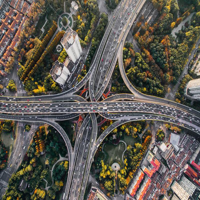

In [29]:
query_image = load_image_from_url(url)
query_image.resize((200,200))


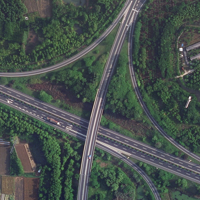
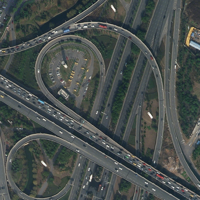
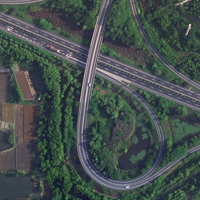
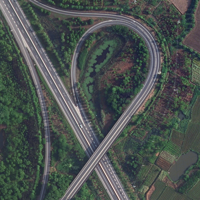
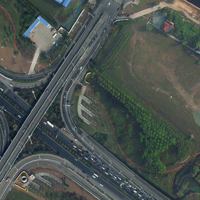
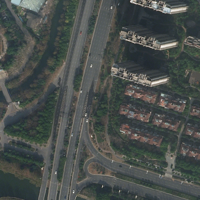

In [30]:
imgs, meta = search_pinecone(query_image)
display_result(imgs)

In [31]:
url = "https://thumbs.dreamstime.com/b/wuhan-city-sunset-night-aerial-photography-scenery-summer-capital-hubei-province-central-china-situated-153963079.jpg"

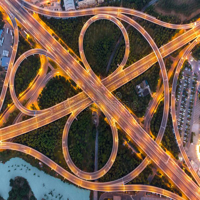

In [32]:
query_image = load_image_from_url(url)
query_image.resize((200,200))


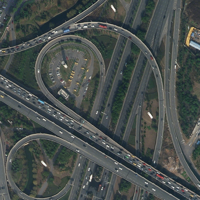
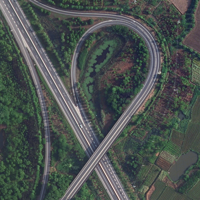
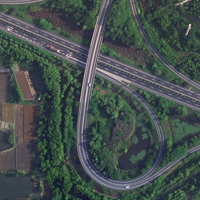
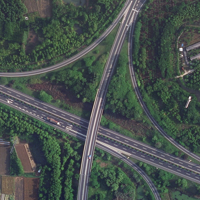
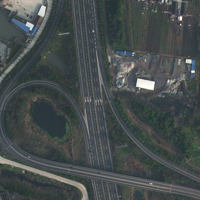
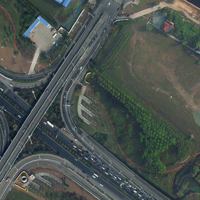

In [33]:
imgs, meta = search_pinecone(query_image)
display_result(imgs)

In [34]:
url = "https://live.staticflickr.com/65535/49126457771_491f670929_b.jpg"

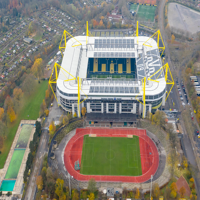

In [35]:
query_image = load_image_from_url(url)
query_image.resize((200,200))


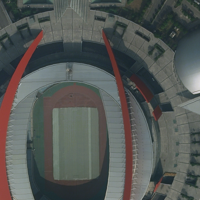
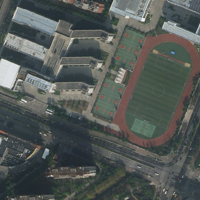
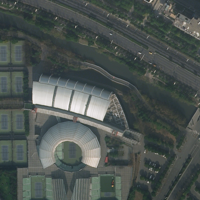
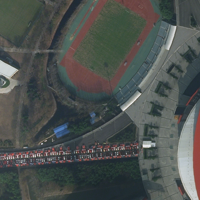
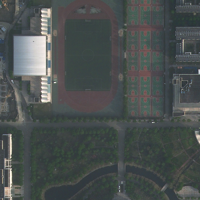
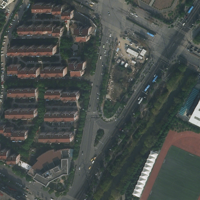

In [36]:
imgs, meta = search_pinecone(query_image)
display_result(imgs)

In [37]:
url = "https://media.architecturaldigest.com/photos/58adccaba4527904a46a646c/master/w_2300,h_1725,c_limit/airport-aerial-views-007.jpg"

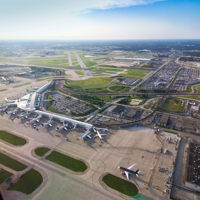

In [38]:
query_image = load_image_from_url(url)
query_image.resize((200,200))


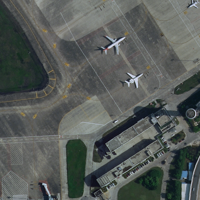
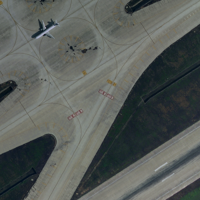
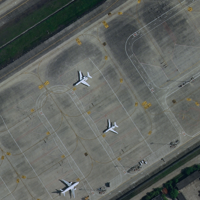
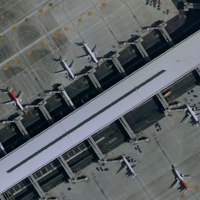
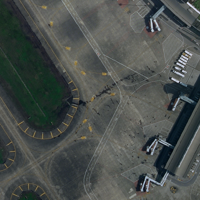
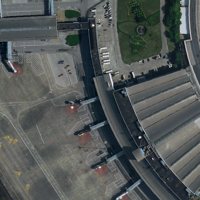

In [39]:
imgs, meta = search_pinecone(query_image)
display_result(imgs)

In [40]:
url = "https://img.freepik.com/premium-photo/aerial-view-shipyard-repairing_33835-1036.jpg"

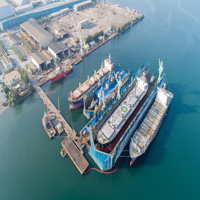

In [41]:
query_image = load_image_from_url(url)
query_image.resize((200,200))


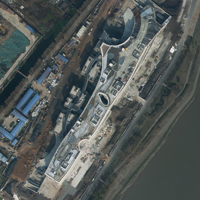
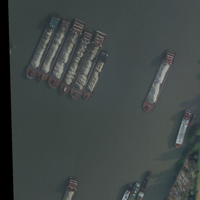
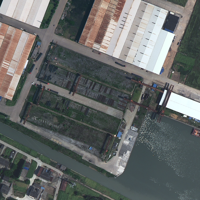
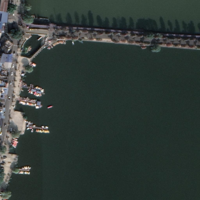
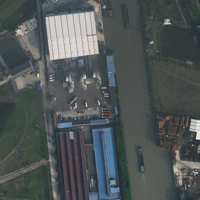
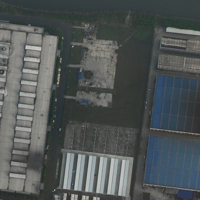

In [42]:
imgs, meta = search_pinecone(query_image)
display_result(imgs)

These all look like great results, showcasing Pinecone's advanced vector search capabilities in satellite image search.

If you have finished with this example, we delete the index to save resources like so:

In [43]:
pinecone.delete_index(index_name)

# Summary

We demonstrated the potential of using Pinecone for satellite image search by leveraging state-of-the-art natural language processing and computer vision models. This approach has a wide range of potential use cases, such as identifying damaged buildings and infrastructure after natural disasters, monitoring deforestation or crop health, identifying areas of urbanization or industrial activity, and more.

The ability to quickly search through large collections of satellite imagery with advanced vector search capabilities can greatly benefit organizations and researchers across various industries, from disaster response to environmental monitoring and urban planning. Overall, Pinecone's efficient and scalable infrastructure, combined with powerful machine learning models, provides an innovative solution for image search that can have a significant impact on real-world problems.